In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import math

# for k fold cross validation accuracy
from sklearn.model_selection import StratifiedKFold

In [4]:
# load in data and labels    
data = np.array(np.loadtxt('data.txt')) # (5000L, 784L) -> note that 784 = 28*28
labels = np.loadtxt('labels.txt') 
dy, dx = data.shape

def most_common(lst):
    return max(set(lst), key=lst.count)

def visualize_trained_map_with_label(clusters, size_k):
    array = np.empty((size_k, size_k))
    
    for i in range(len(clusters)):
        if len(clusters[i]) > 0:
            array[int(i/size_k)][int(i%size_k)] = int(most_common(clusters[i]))
        else:
            array[int(i/size_k)][int(i%size_k)] = -1
    
    ax = sns.heatmap(array, annot=True)

def kohonen_test_supervised(targetdigits = [2, 4, 6, 8], _sigma = 2, _size_k = 6, _eta = 0.9, _tmax = 5000):
    dim = 28*28
    data_range = 255.0
    
    data_and_labels = np.concatenate((data, labels[:, None]), axis = 1)
    
    temp_data = data_and_labels[np.logical_or.reduce([labels==x for x in [targetdigits[0]] ]),:]
    train, test = temp_data[0 : int(0.7 * len(temp_data))], temp_data[int(0.7 * len(temp_data)) : len(temp_data)]
    
    for i in range(1, len(targetdigits)):
        temp_data = data_and_labels[np.logical_or.reduce([labels==x for x in [targetdigits[i]] ]),:]
        train = np.concatenate((train, temp_data[0 : int(0.7 * len(temp_data))]))
        test = np.concatenate((test, temp_data[int(0.7 * len(temp_data)) : len(temp_data)]))
    
    # split into training and testing set
    x_train, y_train = train[:, 0 : len(train[0]) - 1], train[:, -1]
    x_test, y_test = test[:, 0 : len(test[0]) - 1], test[:, -1]
    
    size_k, sigma, eta, tmax = _size_k, _sigma, _eta, _tmax
    
    #initialise the centers randomly
    centers = np.random.rand(size_k**2, dim) * data_range
    
    #build a neighborhood matrix
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))
    
    #set the random order in which the datapoints should be presented
    i_random = np.arange(tmax) % len(train)
    np.random.shuffle(i_random)
    
    for t, i in enumerate(i_random):
        som_step(centers, x_train[i,:],neighbor,eta,sigma)
        
    # for visualization, you can use this:
    for i in range(1, size_k**2+1):
        plb.subplot(size_k,size_k,i)
        
        plb.imshow(np.reshape(centers[i-1,:], [28, 28]),interpolation='bilinear')
        plb.axis('off')
        
    # leave the window open at the end of the loop
    plb.show()
    plb.draw()
    
    kohonen_predict(centers, size_k, x_train, y_train, x_test, y_test)
    
    

def kohonen_learning_curve(targetdigits = [2, 4, 6, 8], _sigma = 2, _size_k = 6, _eta = 0.9, epoch = 10, sigma_decay=False):
    # train kohonen map and compute testing accuracy
    dim = 28*28
    data_range = 255.0
    
    size_k, sigma, eta = _size_k, _sigma, _eta
    
    data_and_labels = np.concatenate((data, labels[:, None]), axis = 1)
    
    temp_data = data_and_labels[np.logical_or.reduce([labels==x for x in [targetdigits[0]] ]),:]
    train, test = temp_data[0 : int(0.7 * len(temp_data))], temp_data[int(0.7 * len(temp_data)) : len(temp_data)]
    
    for i in range(1, len(targetdigits)):
        temp_data = data_and_labels[np.logical_or.reduce([labels==x for x in [targetdigits[i]] ]),:]
        train = np.concatenate((train, temp_data[0 : int(0.7 * len(temp_data))]))
        test = np.concatenate((test, temp_data[int(0.7 * len(temp_data)) : len(temp_data)]))
    
    # split into training and testing set
    x_train, y_train = train[:, 0 : len(train[0]) - 1], train[:, -1]
    x_test, y_test = test[:, 0 : len(test[0]) - 1], test[:, -1]
    
    #initialise the centers randomly, build neighborhood matrix
    centers = np.random.rand(size_k**2, dim) * data_range
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))
    
    ls_accuracy = []
    
    for i in range(epoch):
        # 1. train     
        i_random = np.arange(len(x_train))
        np.random.shuffle(i_random)
        
        for j in range(len(i_random)):
            index = i_random[j]
            sig = sigma
            
            if sigma_decay:
                # exponential decay of sigma
                sig = sigma * math.exp(-0.1*i)
            
            som_step(centers, x_train[index,:],neighbor,eta,sig)
        
        # 2. Get train and test accuracy
        train_accuracy, test_accuracy = kohonen_predict(centers, size_k, x_train, y_train, x_test, y_test, visualize=False)
        
        print('Epoch ' + str(i+1) + ' ------ Train accuracy: ' + 
              str(round(train_accuracy, 3)) + ', Test accuracy: ' + str(round(test_accuracy, 3)))
        
        iterations = len(x_train)*(i+1)
        ls_accuracy.append([iterations, train_accuracy, test_accuracy])
        
    ls_accuracy = np.array(ls_accuracy)
    
    plt.plot(ls_accuracy[:, 0], ls_accuracy[:, 1])
    plt.plot(ls_accuracy[:, 0], ls_accuracy[:, 2])
    
    plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
    plt.show()
    
    # for visualization, you can use this:
    for i in range(1, size_k**2+1):
        plb.subplot(size_k,size_k,i)
        
        plb.imshow(np.reshape(centers[i-1,:], [28, 28]),interpolation='bilinear')
        plb.axis('off')
        
    # leave the window open at the end of the loop
    plb.show()
    plb.draw()
    
    kohonen_predict(centers, size_k, x_train, y_train, x_test, y_test, visualize=True)
    
    
def kohonen_predict(centers, size_k, x_train, y_train, x_test, y_test, visualize = True):
    # identify 'clusters', treat each winning neuron (based on training dataset) as a cluster itself
    clusters = [[] for i in range(size_k**2)]
    winning_clusters = {}
    
    for i in range(len(x_train)):
        # find winning neuron
        win_location = np.argmin(np.sum((centers - np.resize(x_train[i], (size_k**2, x_train[i].size)))**2,1))
        clusters[win_location].append(int(y_train[i]))
        
    for i in range(len(clusters)):
        if len(clusters[i]) > 0: 
            winning_clusters[i] = most_common(clusters[i])
            
    # visualize trained map with each neuron assigned a label
    if visualize:
        visualize_trained_map_with_label(clusters, size_k)
            
    # Calculate accuracy
    train_accuracy = 0
    test_accuracy = 0
    
    for i in range(len(x_train)):
        min_loc = winning_clusters.keys()[0]
        
        for j in winning_clusters.keys():
            if np.linalg.norm(x_train[i] - centers[j]) < np.linalg.norm(x_train[i] - centers[min_loc]):
                min_loc = j
                
        if int(winning_clusters[min_loc]) == int(y_train[i]):
            train_accuracy += 1
    
    if visualize:
        print("Number of correct predictions for training set: " + str(train_accuracy))
        print("Training accuracy: " + str(float(train_accuracy)/len(x_train)))
        print("---------------------------------------")
    
    for i in range(len(x_test)):
        min_loc = winning_clusters.keys()[0]
        
        for j in winning_clusters.keys():
            if np.linalg.norm(x_test[i] - centers[j]) < np.linalg.norm(x_test[i] - centers[min_loc]):
                min_loc = j
                
        if int(winning_clusters[min_loc]) == int(y_test[i]):
            test_accuracy += 1
    
    if visualize:
        print("Number of correct predictions for testing set: " + str(test_accuracy))
        print("Test accuracy: " + str(float(test_accuracy)/len(x_test)))
        print("---------------------------------------")
    
    train_accuracy = float(train_accuracy)/len(x_train)
    test_accuracy = float(test_accuracy)/len(x_test)
    return train_accuracy, test_accuracy
    
    
    
def som_step(centers,data,neighbor,eta,sigma):
    """Performs one step of the sequential learning for a 
    self-organized map (SOM).
    
      centers = som_step(centers,data,neighbor,eta,sigma)
    
      Input and output arguments: 
       centers  (matrix) cluster centres. Have to be in format:
                         center X dimension
       data     (vector) the actually presented datapoint to be presented in
                         this timestep
       neighbor (matrix) the coordinates of the centers in the desired
                         neighborhood.
       eta      (scalar) a learning rate
       sigma    (scalar) the width of the gaussian neighborhood function.
                         Effectively describing the width of the neighborhood
    """
    
    size_k = int(np.sqrt(len(centers)))
    
    #find the best matching unit via the minimal distance to the datapoint
    b = np.argmin(np.sum((centers - np.resize(data, (size_k**2, data.size)))**2,1))

    # find coordinates of the winner
    a,b = np.nonzero(neighbor == b)
        
    # update all units
    for j in range(size_k**2):
        # find coordinates of this unit
        a1,b1 = np.nonzero(neighbor==j)
        # calculate the distance and discounting factor
        disc=gauss(np.sqrt((a-a1)**2+(b-b1)**2),[0, sigma])
        # update weights        
        centers[j,:] += disc * eta * (data - centers[j,:])
        

def gauss(x,p):
    """Return the gauss function N(x), with mean p[0] and std p[1].
    Normalized such that N(x=p[0]) = 1.
    """
    return np.exp((-(x - p[0])**2) / (2 * p[1]**2))

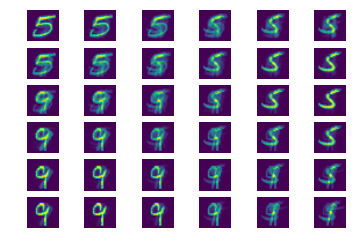

Number of correct predictions for training set: 928
Training accuracy: 0.662857142857
---------------------------------------
Number of correct predictions for testing set: 388
Test accuracy: 0.646666666667
---------------------------------------


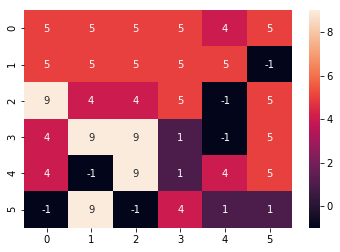

In [3]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 2,
    'size_k': 6,
    'eta': 0.9,
    'tmax': 5000
}

kohonen_test_supervised(targetdigits = config['targetdigits'], 
                        _sigma = config['sigma'], 
                        _size_k = config['size_k'], 
                        _eta = config['eta'], 
                        _tmax = config['tmax'])

### 1. Start with a Kohonen network of 6x6 neurons that are arranged on a square grid with unit distance and use a Gaussian neighborhood function with (constant) standard deviation $\sigma = 3$ Implement the Kohonen algorithm and apply it to the data in data.txt. Choose a small (constant) learning rate and report how you decide when your algorithm has converged.

To qualitatively measure the performance of a Kohonen map, we tried to use the trained Kohonen map as a classifier to classify unknown input vectors. 

At the end of each epoch of the training procedure, we calculate both training and testing accuracy using the latest Kohonen map and plot the learning curve of the Kohonen map.  

Epoch 1 ------ Train accuracy: 0.315, Test accuracy: 0.287
Epoch 2 ------ Train accuracy: 0.417, Test accuracy: 0.415
Epoch 3 ------ Train accuracy: 0.678, Test accuracy: 0.672
Epoch 4 ------ Train accuracy: 0.744, Test accuracy: 0.692
Epoch 5 ------ Train accuracy: 0.712, Test accuracy: 0.648
Epoch 6 ------ Train accuracy: 0.696, Test accuracy: 0.635
Epoch 7 ------ Train accuracy: 0.696, Test accuracy: 0.658
Epoch 8 ------ Train accuracy: 0.716, Test accuracy: 0.67
Epoch 9 ------ Train accuracy: 0.719, Test accuracy: 0.702
Epoch 10 ------ Train accuracy: 0.716, Test accuracy: 0.665
Epoch 11 ------ Train accuracy: 0.723, Test accuracy: 0.677
Epoch 12 ------ Train accuracy: 0.724, Test accuracy: 0.658
Epoch 13 ------ Train accuracy: 0.721, Test accuracy: 0.665
Epoch 14 ------ Train accuracy: 0.725, Test accuracy: 0.667
Epoch 15 ------ Train accuracy: 0.729, Test accuracy: 0.667
Epoch 16 ------ Train accuracy: 0.728, Test accuracy: 0.662
Epoch 17 ------ Train accuracy: 0.727, Test accura

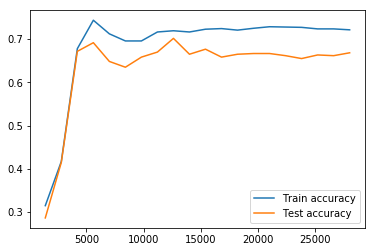

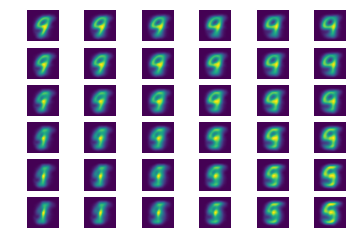

Number of correct predictions for training set: 1010
Training accuracy: 0.721428571429
---------------------------------------
Number of correct predictions for testing set: 401
Test accuracy: 0.668333333333
---------------------------------------


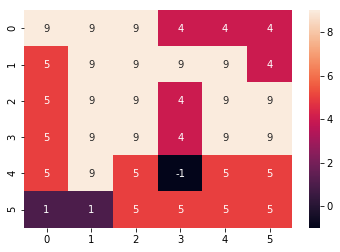

In [6]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 6,
    'eta': 0.0008,
    'epoch': 20
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

### 2. Using the information in (labels.txt), find a way to automatically assign one digit to each prototype that is represented best by it. Visualize and interpret your results.

### 3. Explore different sizes of the Kohonen map (try at least 3 different sizes, not less than 36 units). Explore different widths of the neighborhood function (try at least $\sigma = 1, 3, 5$). Describe the role of the width of the neighborhood function. Does the optimal width depend on the size of the Kohonen map?

#### Vary size_k

Epoch 1 ------ Train accuracy: 0.338, Test accuracy: 0.34
Epoch 2 ------ Train accuracy: 0.389, Test accuracy: 0.342
Epoch 3 ------ Train accuracy: 0.44, Test accuracy: 0.43
Epoch 4 ------ Train accuracy: 0.52, Test accuracy: 0.465
Epoch 5 ------ Train accuracy: 0.54, Test accuracy: 0.487
Epoch 6 ------ Train accuracy: 0.519, Test accuracy: 0.495
Epoch 7 ------ Train accuracy: 0.549, Test accuracy: 0.517
Epoch 8 ------ Train accuracy: 0.564, Test accuracy: 0.515
Epoch 9 ------ Train accuracy: 0.589, Test accuracy: 0.53
Epoch 10 ------ Train accuracy: 0.624, Test accuracy: 0.558
Epoch 11 ------ Train accuracy: 0.658, Test accuracy: 0.582
Epoch 12 ------ Train accuracy: 0.689, Test accuracy: 0.603
Epoch 13 ------ Train accuracy: 0.693, Test accuracy: 0.64
Epoch 14 ------ Train accuracy: 0.701, Test accuracy: 0.648
Epoch 15 ------ Train accuracy: 0.707, Test accuracy: 0.637
Epoch 16 ------ Train accuracy: 0.71, Test accuracy: 0.642
Epoch 17 ------ Train accuracy: 0.711, Test accuracy: 0.6

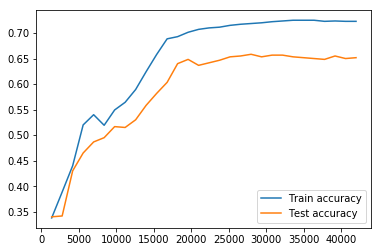

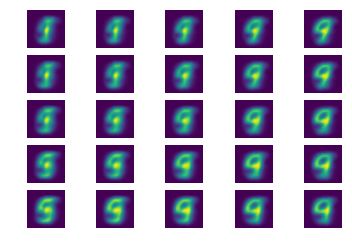

Number of correct predictions for training set: 1012
Training accuracy: 0.722857142857
---------------------------------------
Number of correct predictions for testing set: 391
Test accuracy: 0.651666666667
---------------------------------------


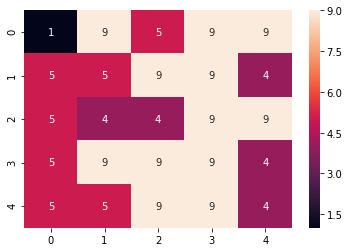

In [13]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 5,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.292, Test accuracy: 0.29
Epoch 2 ------ Train accuracy: 0.356, Test accuracy: 0.353
Epoch 3 ------ Train accuracy: 0.526, Test accuracy: 0.448
Epoch 4 ------ Train accuracy: 0.613, Test accuracy: 0.565
Epoch 5 ------ Train accuracy: 0.645, Test accuracy: 0.587
Epoch 6 ------ Train accuracy: 0.675, Test accuracy: 0.603
Epoch 7 ------ Train accuracy: 0.688, Test accuracy: 0.632
Epoch 8 ------ Train accuracy: 0.7, Test accuracy: 0.633
Epoch 9 ------ Train accuracy: 0.703, Test accuracy: 0.642
Epoch 10 ------ Train accuracy: 0.709, Test accuracy: 0.647
Epoch 11 ------ Train accuracy: 0.721, Test accuracy: 0.667
Epoch 12 ------ Train accuracy: 0.717, Test accuracy: 0.668
Epoch 13 ------ Train accuracy: 0.714, Test accuracy: 0.657
Epoch 14 ------ Train accuracy: 0.715, Test accuracy: 0.663
Epoch 15 ------ Train accuracy: 0.717, Test accuracy: 0.662
Epoch 16 ------ Train accuracy: 0.716, Test accuracy: 0.667
Epoch 17 ------ Train accuracy: 0.717, Test accuracy

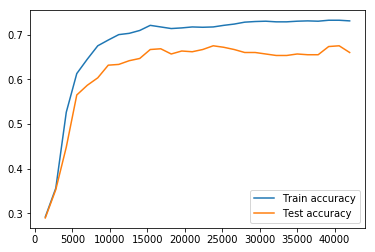

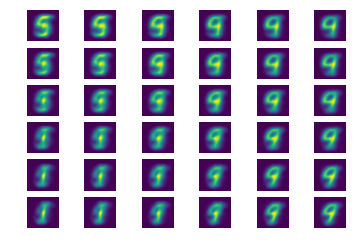

Number of correct predictions for training set: 1023
Training accuracy: 0.730714285714
---------------------------------------
Number of correct predictions for testing set: 396
Test accuracy: 0.66
---------------------------------------


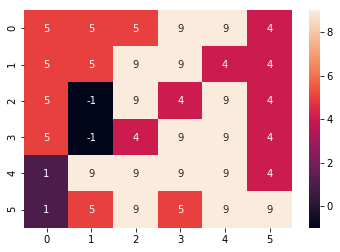

In [14]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 6,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.421, Test accuracy: 0.408
Epoch 2 ------ Train accuracy: 0.503, Test accuracy: 0.48
Epoch 3 ------ Train accuracy: 0.646, Test accuracy: 0.642
Epoch 4 ------ Train accuracy: 0.75, Test accuracy: 0.708
Epoch 5 ------ Train accuracy: 0.761, Test accuracy: 0.725
Epoch 6 ------ Train accuracy: 0.771, Test accuracy: 0.705
Epoch 7 ------ Train accuracy: 0.775, Test accuracy: 0.747
Epoch 8 ------ Train accuracy: 0.766, Test accuracy: 0.718
Epoch 9 ------ Train accuracy: 0.764, Test accuracy: 0.7
Epoch 10 ------ Train accuracy: 0.756, Test accuracy: 0.727
Epoch 11 ------ Train accuracy: 0.754, Test accuracy: 0.735
Epoch 12 ------ Train accuracy: 0.748, Test accuracy: 0.73
Epoch 13 ------ Train accuracy: 0.749, Test accuracy: 0.7
Epoch 14 ------ Train accuracy: 0.745, Test accuracy: 0.695
Epoch 15 ------ Train accuracy: 0.744, Test accuracy: 0.688
Epoch 16 ------ Train accuracy: 0.74, Test accuracy: 0.688
Epoch 17 ------ Train accuracy: 0.739, Test accuracy: 0.6

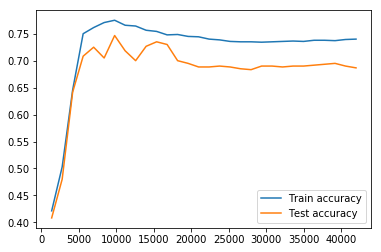

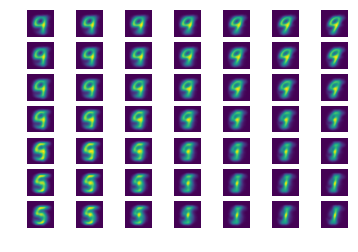

Number of correct predictions for training set: 1036
Training accuracy: 0.74
---------------------------------------
Number of correct predictions for testing set: 412
Test accuracy: 0.686666666667
---------------------------------------


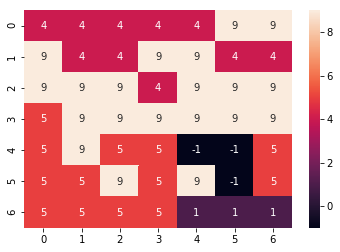

In [15]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 7,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.266, Test accuracy: 0.263
Epoch 2 ------ Train accuracy: 0.351, Test accuracy: 0.357
Epoch 3 ------ Train accuracy: 0.555, Test accuracy: 0.513
Epoch 4 ------ Train accuracy: 0.665, Test accuracy: 0.635
Epoch 5 ------ Train accuracy: 0.709, Test accuracy: 0.655
Epoch 6 ------ Train accuracy: 0.722, Test accuracy: 0.657
Epoch 7 ------ Train accuracy: 0.73, Test accuracy: 0.672
Epoch 8 ------ Train accuracy: 0.754, Test accuracy: 0.687
Epoch 9 ------ Train accuracy: 0.747, Test accuracy: 0.697
Epoch 10 ------ Train accuracy: 0.746, Test accuracy: 0.687
Epoch 11 ------ Train accuracy: 0.74, Test accuracy: 0.683
Epoch 12 ------ Train accuracy: 0.744, Test accuracy: 0.708
Epoch 13 ------ Train accuracy: 0.748, Test accuracy: 0.708
Epoch 14 ------ Train accuracy: 0.744, Test accuracy: 0.708
Epoch 15 ------ Train accuracy: 0.741, Test accuracy: 0.693
Epoch 16 ------ Train accuracy: 0.741, Test accuracy: 0.692
Epoch 17 ------ Train accuracy: 0.738, Test accurac

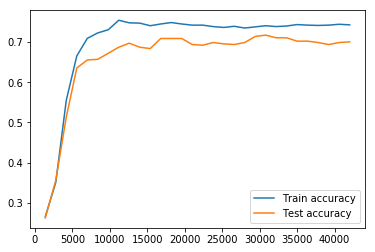

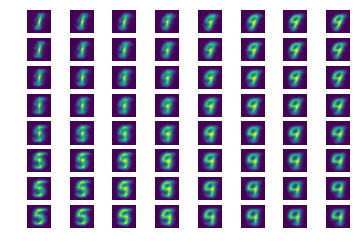

Number of correct predictions for training set: 1039
Training accuracy: 0.742142857143
---------------------------------------
Number of correct predictions for testing set: 420
Test accuracy: 0.7
---------------------------------------


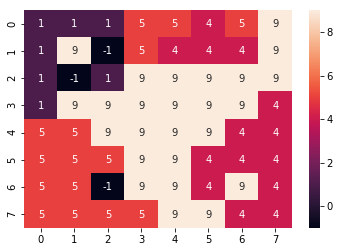

In [16]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.284, Test accuracy: 0.272
Epoch 2 ------ Train accuracy: 0.409, Test accuracy: 0.387
Epoch 3 ------ Train accuracy: 0.645, Test accuracy: 0.6
Epoch 4 ------ Train accuracy: 0.712, Test accuracy: 0.66
Epoch 5 ------ Train accuracy: 0.728, Test accuracy: 0.67
Epoch 6 ------ Train accuracy: 0.746, Test accuracy: 0.668
Epoch 7 ------ Train accuracy: 0.743, Test accuracy: 0.705
Epoch 8 ------ Train accuracy: 0.747, Test accuracy: 0.692
Epoch 9 ------ Train accuracy: 0.745, Test accuracy: 0.673
Epoch 10 ------ Train accuracy: 0.744, Test accuracy: 0.663
Epoch 11 ------ Train accuracy: 0.75, Test accuracy: 0.677
Epoch 12 ------ Train accuracy: 0.754, Test accuracy: 0.67
Epoch 13 ------ Train accuracy: 0.751, Test accuracy: 0.668
Epoch 14 ------ Train accuracy: 0.75, Test accuracy: 0.677
Epoch 15 ------ Train accuracy: 0.749, Test accuracy: 0.683
Epoch 16 ------ Train accuracy: 0.751, Test accuracy: 0.687
Epoch 17 ------ Train accuracy: 0.756, Test accuracy: 0.

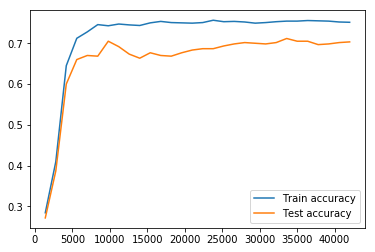

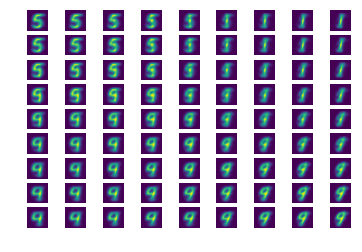

Number of correct predictions for training set: 1052
Training accuracy: 0.751428571429
---------------------------------------
Number of correct predictions for testing set: 422
Test accuracy: 0.703333333333
---------------------------------------


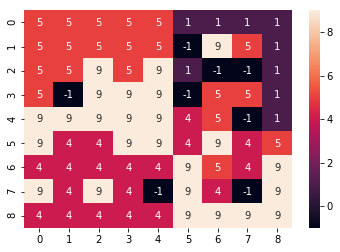

In [17]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 9,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.342, Test accuracy: 0.338
Epoch 2 ------ Train accuracy: 0.474, Test accuracy: 0.463
Epoch 3 ------ Train accuracy: 0.706, Test accuracy: 0.633
Epoch 4 ------ Train accuracy: 0.706, Test accuracy: 0.663
Epoch 5 ------ Train accuracy: 0.719, Test accuracy: 0.653
Epoch 6 ------ Train accuracy: 0.726, Test accuracy: 0.703
Epoch 7 ------ Train accuracy: 0.731, Test accuracy: 0.69
Epoch 8 ------ Train accuracy: 0.729, Test accuracy: 0.677
Epoch 9 ------ Train accuracy: 0.731, Test accuracy: 0.678
Epoch 10 ------ Train accuracy: 0.733, Test accuracy: 0.702
Epoch 11 ------ Train accuracy: 0.741, Test accuracy: 0.712
Epoch 12 ------ Train accuracy: 0.756, Test accuracy: 0.723
Epoch 13 ------ Train accuracy: 0.751, Test accuracy: 0.727
Epoch 14 ------ Train accuracy: 0.744, Test accuracy: 0.713
Epoch 15 ------ Train accuracy: 0.749, Test accuracy: 0.708
Epoch 16 ------ Train accuracy: 0.749, Test accuracy: 0.71
Epoch 17 ------ Train accuracy: 0.75, Test accuracy

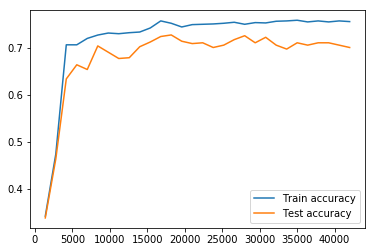

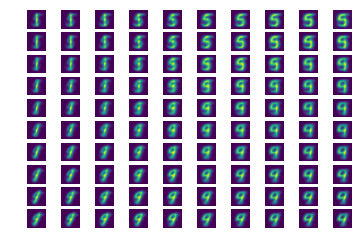

Number of correct predictions for training set: 1057
Training accuracy: 0.755
---------------------------------------
Number of correct predictions for testing set: 420
Test accuracy: 0.7
---------------------------------------


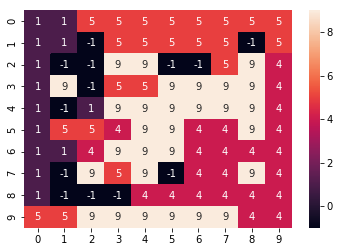

In [18]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 10,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.272, Test accuracy: 0.272
Epoch 2 ------ Train accuracy: 0.418, Test accuracy: 0.402
Epoch 3 ------ Train accuracy: 0.678, Test accuracy: 0.608
Epoch 4 ------ Train accuracy: 0.761, Test accuracy: 0.712
Epoch 5 ------ Train accuracy: 0.748, Test accuracy: 0.722
Epoch 6 ------ Train accuracy: 0.765, Test accuracy: 0.747
Epoch 7 ------ Train accuracy: 0.778, Test accuracy: 0.722
Epoch 8 ------ Train accuracy: 0.768, Test accuracy: 0.708
Epoch 9 ------ Train accuracy: 0.761, Test accuracy: 0.73
Epoch 10 ------ Train accuracy: 0.77, Test accuracy: 0.725
Epoch 11 ------ Train accuracy: 0.771, Test accuracy: 0.737
Epoch 12 ------ Train accuracy: 0.774, Test accuracy: 0.737
Epoch 13 ------ Train accuracy: 0.776, Test accuracy: 0.75
Epoch 14 ------ Train accuracy: 0.773, Test accuracy: 0.732
Epoch 15 ------ Train accuracy: 0.773, Test accuracy: 0.743
Epoch 16 ------ Train accuracy: 0.776, Test accuracy: 0.727
Epoch 17 ------ Train accuracy: 0.773, Test accuracy

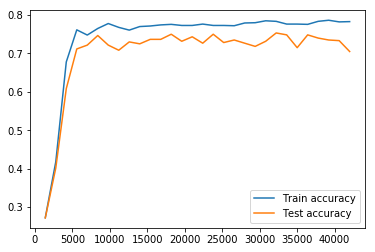

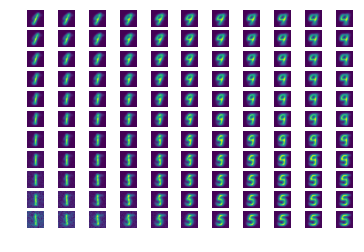

Number of correct predictions for training set: 1096
Training accuracy: 0.782857142857
---------------------------------------
Number of correct predictions for testing set: 423
Test accuracy: 0.705
---------------------------------------


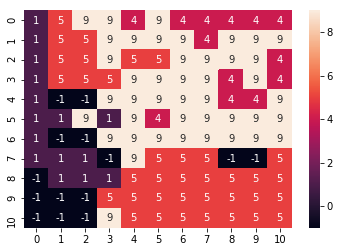

In [19]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 11,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.259, Test accuracy: 0.267
Epoch 2 ------ Train accuracy: 0.407, Test accuracy: 0.38
Epoch 3 ------ Train accuracy: 0.554, Test accuracy: 0.515
Epoch 4 ------ Train accuracy: 0.681, Test accuracy: 0.645
Epoch 5 ------ Train accuracy: 0.74, Test accuracy: 0.695
Epoch 6 ------ Train accuracy: 0.746, Test accuracy: 0.663
Epoch 7 ------ Train accuracy: 0.756, Test accuracy: 0.672
Epoch 8 ------ Train accuracy: 0.771, Test accuracy: 0.693
Epoch 9 ------ Train accuracy: 0.769, Test accuracy: 0.727
Epoch 10 ------ Train accuracy: 0.761, Test accuracy: 0.718
Epoch 11 ------ Train accuracy: 0.761, Test accuracy: 0.698
Epoch 12 ------ Train accuracy: 0.771, Test accuracy: 0.727
Epoch 13 ------ Train accuracy: 0.778, Test accuracy: 0.707
Epoch 14 ------ Train accuracy: 0.773, Test accuracy: 0.697
Epoch 15 ------ Train accuracy: 0.774, Test accuracy: 0.728
Epoch 16 ------ Train accuracy: 0.774, Test accuracy: 0.695
Epoch 17 ------ Train accuracy: 0.776, Test accurac

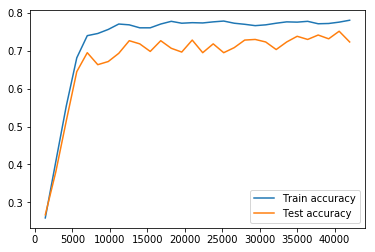

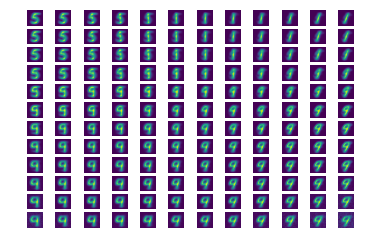

Number of correct predictions for training set: 1093
Training accuracy: 0.780714285714
---------------------------------------
Number of correct predictions for testing set: 434
Test accuracy: 0.723333333333
---------------------------------------


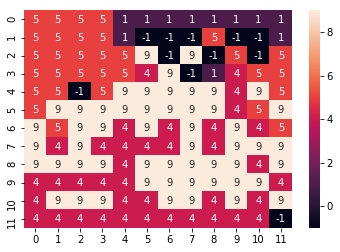

In [20]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 12,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.284, Test accuracy: 0.288
Epoch 2 ------ Train accuracy: 0.419, Test accuracy: 0.395
Epoch 3 ------ Train accuracy: 0.62, Test accuracy: 0.617
Epoch 4 ------ Train accuracy: 0.698, Test accuracy: 0.613
Epoch 5 ------ Train accuracy: 0.726, Test accuracy: 0.655
Epoch 6 ------ Train accuracy: 0.733, Test accuracy: 0.698
Epoch 7 ------ Train accuracy: 0.747, Test accuracy: 0.712
Epoch 8 ------ Train accuracy: 0.741, Test accuracy: 0.692
Epoch 9 ------ Train accuracy: 0.761, Test accuracy: 0.707
Epoch 10 ------ Train accuracy: 0.759, Test accuracy: 0.71
Epoch 11 ------ Train accuracy: 0.767, Test accuracy: 0.715
Epoch 12 ------ Train accuracy: 0.772, Test accuracy: 0.717
Epoch 13 ------ Train accuracy: 0.776, Test accuracy: 0.733
Epoch 14 ------ Train accuracy: 0.776, Test accuracy: 0.71
Epoch 15 ------ Train accuracy: 0.788, Test accuracy: 0.715
Epoch 16 ------ Train accuracy: 0.784, Test accuracy: 0.705
Epoch 17 ------ Train accuracy: 0.789, Test accuracy

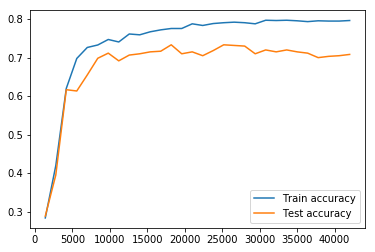

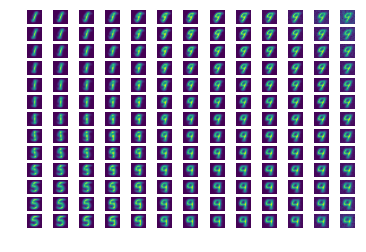

Number of correct predictions for training set: 1115
Training accuracy: 0.796428571429
---------------------------------------
Number of correct predictions for testing set: 425
Test accuracy: 0.708333333333
---------------------------------------


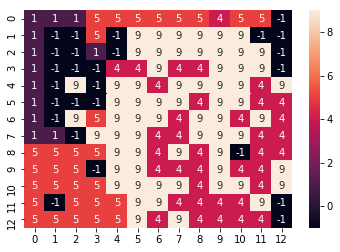

In [21]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 13,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.341, Test accuracy: 0.323
Epoch 2 ------ Train accuracy: 0.443, Test accuracy: 0.418
Epoch 3 ------ Train accuracy: 0.544, Test accuracy: 0.518
Epoch 4 ------ Train accuracy: 0.662, Test accuracy: 0.585
Epoch 5 ------ Train accuracy: 0.674, Test accuracy: 0.603
Epoch 6 ------ Train accuracy: 0.706, Test accuracy: 0.645
Epoch 7 ------ Train accuracy: 0.731, Test accuracy: 0.667
Epoch 8 ------ Train accuracy: 0.726, Test accuracy: 0.648
Epoch 9 ------ Train accuracy: 0.741, Test accuracy: 0.658
Epoch 10 ------ Train accuracy: 0.741, Test accuracy: 0.678
Epoch 11 ------ Train accuracy: 0.737, Test accuracy: 0.697
Epoch 12 ------ Train accuracy: 0.747, Test accuracy: 0.695
Epoch 13 ------ Train accuracy: 0.75, Test accuracy: 0.687
Epoch 14 ------ Train accuracy: 0.749, Test accuracy: 0.683
Epoch 15 ------ Train accuracy: 0.746, Test accuracy: 0.702
Epoch 16 ------ Train accuracy: 0.756, Test accuracy: 0.713
Epoch 17 ------ Train accuracy: 0.76, Test accurac

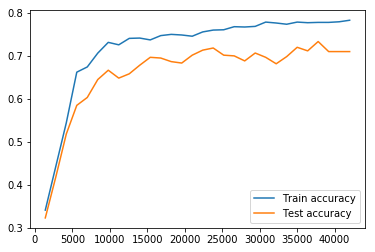

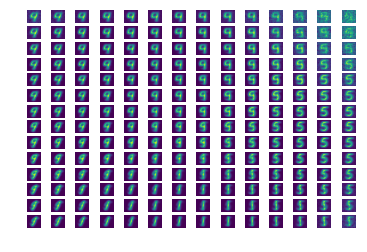

Number of correct predictions for training set: 1096
Training accuracy: 0.782857142857
---------------------------------------
Number of correct predictions for testing set: 426
Test accuracy: 0.71
---------------------------------------


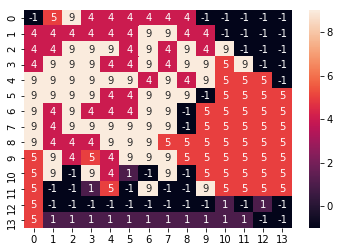

In [22]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 14,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.345, Test accuracy: 0.335
Epoch 2 ------ Train accuracy: 0.451, Test accuracy: 0.423
Epoch 3 ------ Train accuracy: 0.614, Test accuracy: 0.595
Epoch 4 ------ Train accuracy: 0.733, Test accuracy: 0.69
Epoch 5 ------ Train accuracy: 0.751, Test accuracy: 0.7
Epoch 6 ------ Train accuracy: 0.771, Test accuracy: 0.72
Epoch 7 ------ Train accuracy: 0.765, Test accuracy: 0.718
Epoch 8 ------ Train accuracy: 0.767, Test accuracy: 0.713
Epoch 9 ------ Train accuracy: 0.762, Test accuracy: 0.738
Epoch 10 ------ Train accuracy: 0.762, Test accuracy: 0.72
Epoch 11 ------ Train accuracy: 0.761, Test accuracy: 0.683
Epoch 12 ------ Train accuracy: 0.764, Test accuracy: 0.687
Epoch 13 ------ Train accuracy: 0.768, Test accuracy: 0.683
Epoch 14 ------ Train accuracy: 0.767, Test accuracy: 0.693
Epoch 15 ------ Train accuracy: 0.766, Test accuracy: 0.712
Epoch 16 ------ Train accuracy: 0.768, Test accuracy: 0.702
Epoch 17 ------ Train accuracy: 0.764, Test accuracy: 

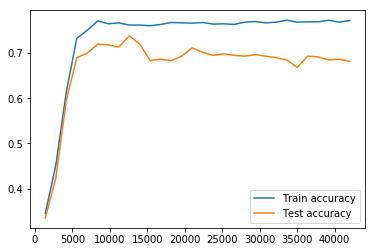

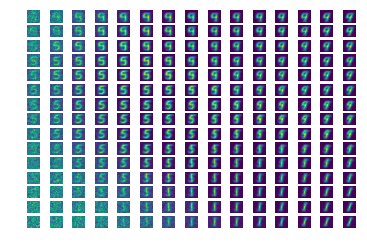

Number of correct predictions for training set: 1081
Training accuracy: 0.772142857143
---------------------------------------
Number of correct predictions for testing set: 409
Test accuracy: 0.681666666667
---------------------------------------


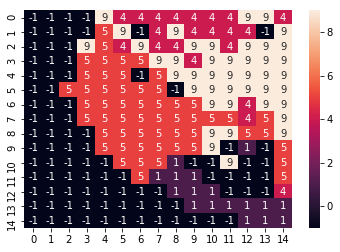

In [23]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 15,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.304, Test accuracy: 0.3
Epoch 2 ------ Train accuracy: 0.436, Test accuracy: 0.413
Epoch 3 ------ Train accuracy: 0.606, Test accuracy: 0.6
Epoch 4 ------ Train accuracy: 0.659, Test accuracy: 0.605
Epoch 5 ------ Train accuracy: 0.724, Test accuracy: 0.683
Epoch 6 ------ Train accuracy: 0.717, Test accuracy: 0.665
Epoch 7 ------ Train accuracy: 0.718, Test accuracy: 0.66
Epoch 8 ------ Train accuracy: 0.716, Test accuracy: 0.633
Epoch 9 ------ Train accuracy: 0.726, Test accuracy: 0.648
Epoch 10 ------ Train accuracy: 0.721, Test accuracy: 0.65
Epoch 11 ------ Train accuracy: 0.721, Test accuracy: 0.658
Epoch 12 ------ Train accuracy: 0.736, Test accuracy: 0.675
Epoch 13 ------ Train accuracy: 0.746, Test accuracy: 0.65
Epoch 14 ------ Train accuracy: 0.741, Test accuracy: 0.628
Epoch 15 ------ Train accuracy: 0.74, Test accuracy: 0.637
Epoch 16 ------ Train accuracy: 0.734, Test accuracy: 0.662
Epoch 17 ------ Train accuracy: 0.746, Test accuracy: 0.6

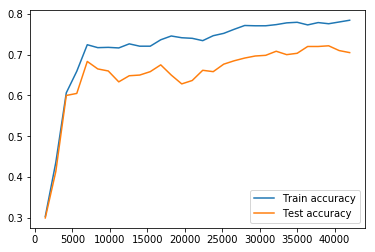

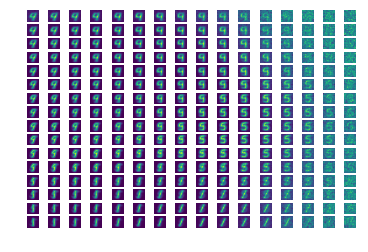

Number of correct predictions for training set: 1098
Training accuracy: 0.784285714286
---------------------------------------
Number of correct predictions for testing set: 423
Test accuracy: 0.705
---------------------------------------


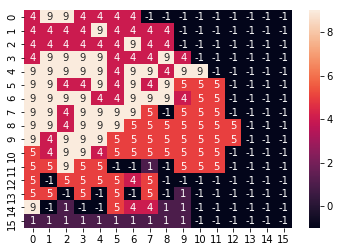

In [24]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 16,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

In [53]:
import pandas as pd
test_results = {}
x = np.array([[5, 72.3, 'Train'], 
              [6, 73.0, 'Train'],
              [7, 74.0, 'Train'],
              [8, 74.2, 'Train'],
              [9, 75.1, 'Train'],
              [10, 75.5, 'Train'],
              [11, 78.3, 'Train'],
              [12, 78.1, 'Train'],
              [13, 79.6, 'Train'],
              [14, 78.3, 'Train'],
              [15, 77.2, 'Train'],
              [16, 78.4, 'Train'],
              
              [5, 65.2, 'Test'], 
              [6, 66.0, 'Test'],
              [7, 68.7, 'Test'],
              [8, 70.0, 'Test'],
              [9, 70.3, 'Test'],
              [10, 70.0, 'Test'],
              [11, 70.5, 'Test'],
              [12, 72.3, 'Test'],
              [13, 70.8, 'Test'],
              [14, 71.0, 'Test'],
              [15, 68.2, 'Test'],
              [16, 70.5, 'Test'],
             ])
x = pd.DataFrame(x, columns = ['size_k', 'Accuracy', 'Dataset'])
x['size_k'] = pd.to_numeric(x['size_k'])
x['Accuracy'] = pd.to_numeric(x['Accuracy'])
test_results['vary_size'] = x

Text(0.5,1,u'sigma = 3, eta = 0.0008, epoch = 30')

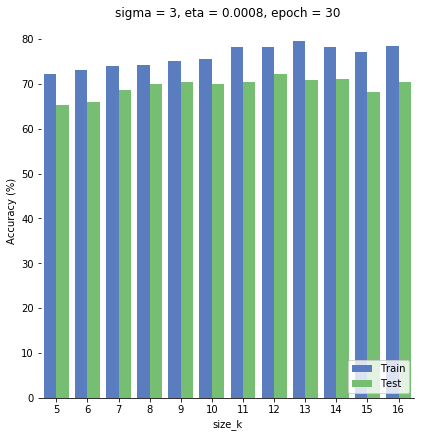

In [86]:
# sns.barplot(x='size_k', y='Accuracy', hue='Dataset', data=test_results['vary_size'], legend = False)

g = sns.factorplot("size_k", "Accuracy", "Dataset",
                    data=test_results['vary_size'], kind="bar",
                    size=6, palette="muted",
                   legend_out=False)
g.despine(left=True)
plt.legend(loc='lower right')
g.set_ylabels("Accuracy (%)")
plt.title("sigma = 3, eta = 0.0008, epoch = 30")

# plt.legend(loc='lower right')

#### Vary sigma

Epoch 1 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 2 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 3 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 4 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 5 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 6 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 7 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 8 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 9 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 10 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 11 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 12 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 13 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 14 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 15 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 16 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 17 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 18 ------ Train a

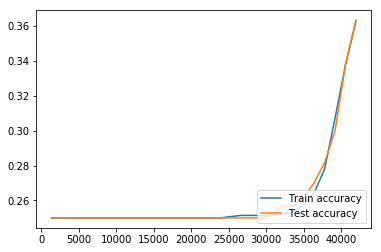

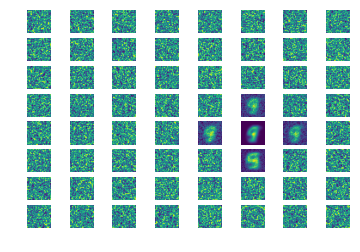

Number of correct predictions for training set: 508
Training accuracy: 0.362857142857
---------------------------------------
Number of correct predictions for testing set: 218
Test accuracy: 0.363333333333
---------------------------------------


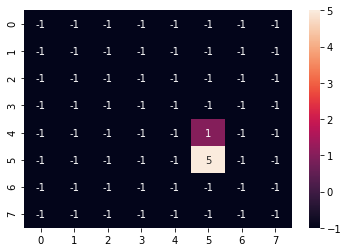

In [83]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 0.4,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 2 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 3 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 4 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 5 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 6 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 7 ------ Train accuracy: 0.251, Test accuracy: 0.252
Epoch 8 ------ Train accuracy: 0.255, Test accuracy: 0.253
Epoch 9 ------ Train accuracy: 0.264, Test accuracy: 0.267
Epoch 10 ------ Train accuracy: 0.28, Test accuracy: 0.282
Epoch 11 ------ Train accuracy: 0.316, Test accuracy: 0.315
Epoch 12 ------ Train accuracy: 0.376, Test accuracy: 0.353
Epoch 13 ------ Train accuracy: 0.45, Test accuracy: 0.413
Epoch 14 ------ Train accuracy: 0.516, Test accuracy: 0.467
Epoch 15 ------ Train accuracy: 0.566, Test accuracy: 0.535
Epoch 16 ------ Train accuracy: 0.622, Test accuracy: 0.577
Epoch 17 ------ Train accuracy: 0.652, Test accuracy: 0.61
Epoc

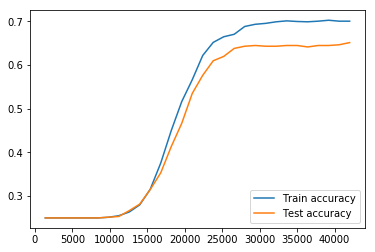

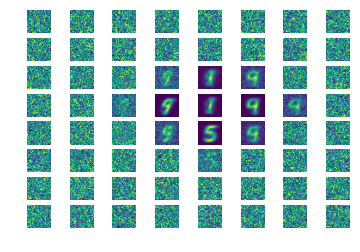

Number of correct predictions for training set: 981
Training accuracy: 0.700714285714
---------------------------------------
Number of correct predictions for testing set: 391
Test accuracy: 0.651666666667
---------------------------------------


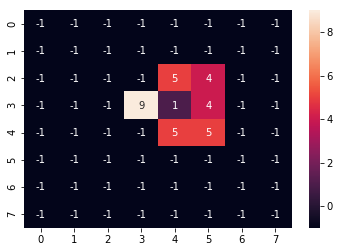

In [81]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 0.5,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.25, Test accuracy: 0.25
Epoch 2 ------ Train accuracy: 0.252, Test accuracy: 0.25
Epoch 3 ------ Train accuracy: 0.329, Test accuracy: 0.317
Epoch 4 ------ Train accuracy: 0.562, Test accuracy: 0.532
Epoch 5 ------ Train accuracy: 0.668, Test accuracy: 0.627
Epoch 6 ------ Train accuracy: 0.649, Test accuracy: 0.622
Epoch 7 ------ Train accuracy: 0.646, Test accuracy: 0.642
Epoch 8 ------ Train accuracy: 0.688, Test accuracy: 0.652
Epoch 9 ------ Train accuracy: 0.684, Test accuracy: 0.643
Epoch 10 ------ Train accuracy: 0.687, Test accuracy: 0.632
Epoch 11 ------ Train accuracy: 0.702, Test accuracy: 0.638
Epoch 12 ------ Train accuracy: 0.714, Test accuracy: 0.645
Epoch 13 ------ Train accuracy: 0.718, Test accuracy: 0.663
Epoch 14 ------ Train accuracy: 0.726, Test accuracy: 0.698
Epoch 15 ------ Train accuracy: 0.731, Test accuracy: 0.703
Epoch 16 ------ Train accuracy: 0.731, Test accuracy: 0.713
Epoch 17 ------ Train accuracy: 0.739, Test accuracy

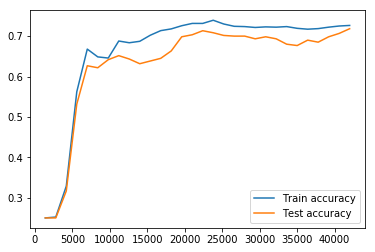

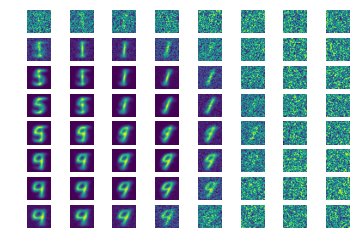

Number of correct predictions for training set: 1017
Training accuracy: 0.726428571429
---------------------------------------
Number of correct predictions for testing set: 431
Test accuracy: 0.718333333333
---------------------------------------


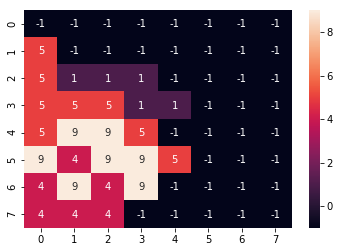

In [72]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 1,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.254, Test accuracy: 0.252
Epoch 2 ------ Train accuracy: 0.327, Test accuracy: 0.317
Epoch 3 ------ Train accuracy: 0.593, Test accuracy: 0.567
Epoch 4 ------ Train accuracy: 0.695, Test accuracy: 0.655
Epoch 5 ------ Train accuracy: 0.7, Test accuracy: 0.648
Epoch 6 ------ Train accuracy: 0.706, Test accuracy: 0.648
Epoch 7 ------ Train accuracy: 0.718, Test accuracy: 0.652
Epoch 8 ------ Train accuracy: 0.726, Test accuracy: 0.667
Epoch 9 ------ Train accuracy: 0.727, Test accuracy: 0.678
Epoch 10 ------ Train accuracy: 0.726, Test accuracy: 0.672
Epoch 11 ------ Train accuracy: 0.726, Test accuracy: 0.667
Epoch 12 ------ Train accuracy: 0.734, Test accuracy: 0.692
Epoch 13 ------ Train accuracy: 0.739, Test accuracy: 0.7
Epoch 14 ------ Train accuracy: 0.741, Test accuracy: 0.698
Epoch 15 ------ Train accuracy: 0.751, Test accuracy: 0.707
Epoch 16 ------ Train accuracy: 0.756, Test accuracy: 0.703
Epoch 17 ------ Train accuracy: 0.753, Test accuracy:

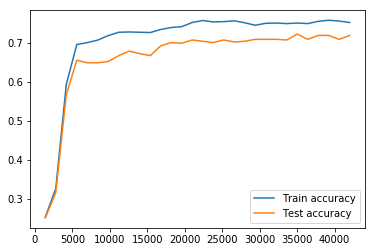

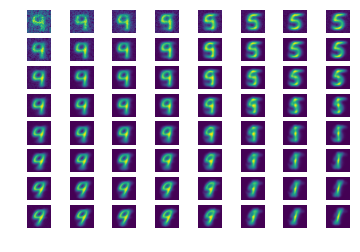

Number of correct predictions for training set: 1052
Training accuracy: 0.751428571429
---------------------------------------
Number of correct predictions for testing set: 431
Test accuracy: 0.718333333333
---------------------------------------


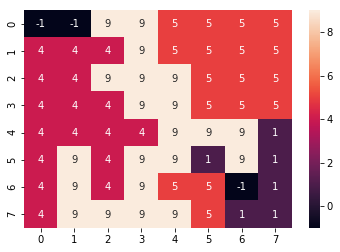

In [73]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 2,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.336, Test accuracy: 0.325
Epoch 2 ------ Train accuracy: 0.443, Test accuracy: 0.427
Epoch 3 ------ Train accuracy: 0.549, Test accuracy: 0.53
Epoch 4 ------ Train accuracy: 0.634, Test accuracy: 0.572
Epoch 5 ------ Train accuracy: 0.704, Test accuracy: 0.643
Epoch 6 ------ Train accuracy: 0.734, Test accuracy: 0.66
Epoch 7 ------ Train accuracy: 0.741, Test accuracy: 0.685
Epoch 8 ------ Train accuracy: 0.752, Test accuracy: 0.687
Epoch 9 ------ Train accuracy: 0.753, Test accuracy: 0.677
Epoch 10 ------ Train accuracy: 0.761, Test accuracy: 0.682
Epoch 11 ------ Train accuracy: 0.75, Test accuracy: 0.695
Epoch 12 ------ Train accuracy: 0.749, Test accuracy: 0.692
Epoch 13 ------ Train accuracy: 0.751, Test accuracy: 0.677
Epoch 14 ------ Train accuracy: 0.755, Test accuracy: 0.685
Epoch 15 ------ Train accuracy: 0.754, Test accuracy: 0.685
Epoch 16 ------ Train accuracy: 0.75, Test accuracy: 0.673
Epoch 17 ------ Train accuracy: 0.752, Test accuracy:

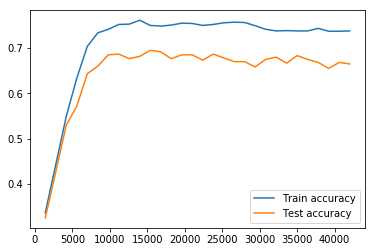

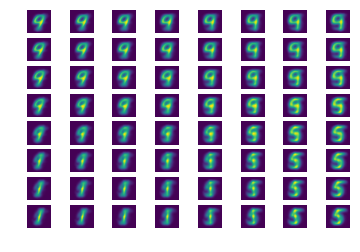

Number of correct predictions for training set: 1033
Training accuracy: 0.737857142857
---------------------------------------
Number of correct predictions for testing set: 399
Test accuracy: 0.665
---------------------------------------


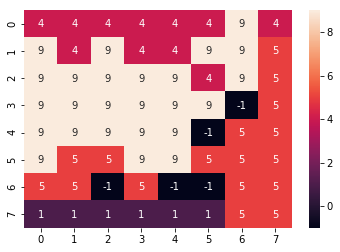

In [74]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.391, Test accuracy: 0.387
Epoch 2 ------ Train accuracy: 0.484, Test accuracy: 0.46
Epoch 3 ------ Train accuracy: 0.595, Test accuracy: 0.533
Epoch 4 ------ Train accuracy: 0.663, Test accuracy: 0.627
Epoch 5 ------ Train accuracy: 0.7, Test accuracy: 0.64
Epoch 6 ------ Train accuracy: 0.694, Test accuracy: 0.633
Epoch 7 ------ Train accuracy: 0.678, Test accuracy: 0.618
Epoch 8 ------ Train accuracy: 0.683, Test accuracy: 0.627
Epoch 9 ------ Train accuracy: 0.681, Test accuracy: 0.602
Epoch 10 ------ Train accuracy: 0.692, Test accuracy: 0.623
Epoch 11 ------ Train accuracy: 0.709, Test accuracy: 0.62
Epoch 12 ------ Train accuracy: 0.714, Test accuracy: 0.627
Epoch 13 ------ Train accuracy: 0.727, Test accuracy: 0.633
Epoch 14 ------ Train accuracy: 0.731, Test accuracy: 0.643
Epoch 15 ------ Train accuracy: 0.736, Test accuracy: 0.633
Epoch 16 ------ Train accuracy: 0.744, Test accuracy: 0.653
Epoch 17 ------ Train accuracy: 0.735, Test accuracy: 

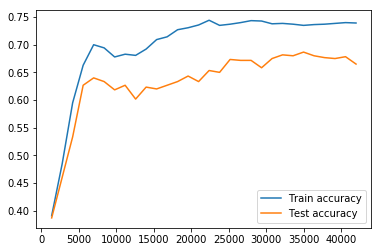

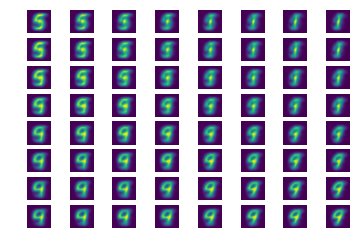

Number of correct predictions for training set: 1035
Training accuracy: 0.739285714286
---------------------------------------
Number of correct predictions for testing set: 399
Test accuracy: 0.665
---------------------------------------


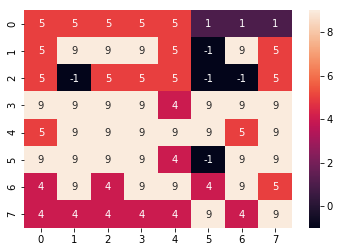

In [75]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 4,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.384, Test accuracy: 0.387
Epoch 2 ------ Train accuracy: 0.431, Test accuracy: 0.43
Epoch 3 ------ Train accuracy: 0.605, Test accuracy: 0.573
Epoch 4 ------ Train accuracy: 0.734, Test accuracy: 0.677
Epoch 5 ------ Train accuracy: 0.734, Test accuracy: 0.675
Epoch 6 ------ Train accuracy: 0.738, Test accuracy: 0.667
Epoch 7 ------ Train accuracy: 0.751, Test accuracy: 0.645
Epoch 8 ------ Train accuracy: 0.743, Test accuracy: 0.682
Epoch 9 ------ Train accuracy: 0.739, Test accuracy: 0.667
Epoch 10 ------ Train accuracy: 0.733, Test accuracy: 0.647
Epoch 11 ------ Train accuracy: 0.731, Test accuracy: 0.652
Epoch 12 ------ Train accuracy: 0.734, Test accuracy: 0.652
Epoch 13 ------ Train accuracy: 0.734, Test accuracy: 0.648
Epoch 14 ------ Train accuracy: 0.741, Test accuracy: 0.652
Epoch 15 ------ Train accuracy: 0.736, Test accuracy: 0.652
Epoch 16 ------ Train accuracy: 0.733, Test accuracy: 0.657
Epoch 17 ------ Train accuracy: 0.734, Test accura

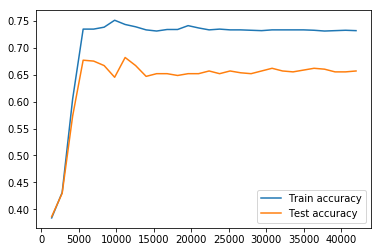

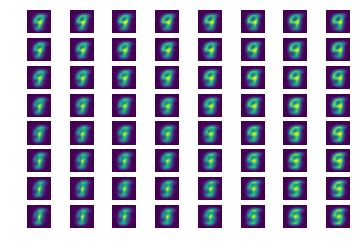

Number of correct predictions for training set: 1024
Training accuracy: 0.731428571429
---------------------------------------
Number of correct predictions for testing set: 394
Test accuracy: 0.656666666667
---------------------------------------


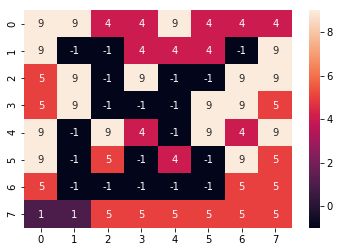

In [76]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 5,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.456, Test accuracy: 0.473
Epoch 2 ------ Train accuracy: 0.542, Test accuracy: 0.517
Epoch 3 ------ Train accuracy: 0.631, Test accuracy: 0.595
Epoch 4 ------ Train accuracy: 0.686, Test accuracy: 0.665
Epoch 5 ------ Train accuracy: 0.7, Test accuracy: 0.617
Epoch 6 ------ Train accuracy: 0.698, Test accuracy: 0.662
Epoch 7 ------ Train accuracy: 0.672, Test accuracy: 0.648
Epoch 8 ------ Train accuracy: 0.673, Test accuracy: 0.608
Epoch 9 ------ Train accuracy: 0.671, Test accuracy: 0.617
Epoch 10 ------ Train accuracy: 0.68, Test accuracy: 0.602
Epoch 11 ------ Train accuracy: 0.686, Test accuracy: 0.612
Epoch 12 ------ Train accuracy: 0.694, Test accuracy: 0.608
Epoch 13 ------ Train accuracy: 0.701, Test accuracy: 0.63
Epoch 14 ------ Train accuracy: 0.705, Test accuracy: 0.623
Epoch 15 ------ Train accuracy: 0.706, Test accuracy: 0.632
Epoch 16 ------ Train accuracy: 0.712, Test accuracy: 0.638
Epoch 17 ------ Train accuracy: 0.715, Test accuracy:

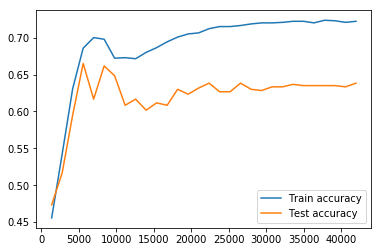

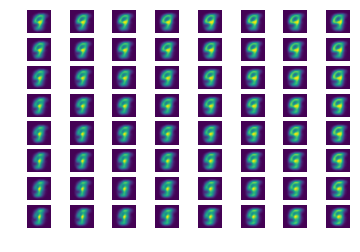

Number of correct predictions for training set: 1011
Training accuracy: 0.722142857143
---------------------------------------
Number of correct predictions for testing set: 383
Test accuracy: 0.638333333333
---------------------------------------


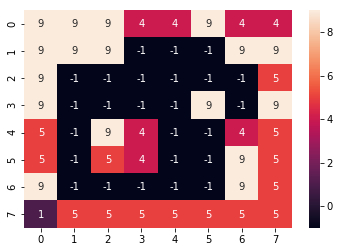

In [77]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 6,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.348, Test accuracy: 0.388
Epoch 2 ------ Train accuracy: 0.576, Test accuracy: 0.577
Epoch 3 ------ Train accuracy: 0.638, Test accuracy: 0.62
Epoch 4 ------ Train accuracy: 0.655, Test accuracy: 0.603
Epoch 5 ------ Train accuracy: 0.664, Test accuracy: 0.603
Epoch 6 ------ Train accuracy: 0.681, Test accuracy: 0.603
Epoch 7 ------ Train accuracy: 0.684, Test accuracy: 0.602
Epoch 8 ------ Train accuracy: 0.687, Test accuracy: 0.61
Epoch 9 ------ Train accuracy: 0.689, Test accuracy: 0.613
Epoch 10 ------ Train accuracy: 0.694, Test accuracy: 0.615
Epoch 11 ------ Train accuracy: 0.696, Test accuracy: 0.627
Epoch 12 ------ Train accuracy: 0.699, Test accuracy: 0.625
Epoch 13 ------ Train accuracy: 0.698, Test accuracy: 0.615
Epoch 14 ------ Train accuracy: 0.698, Test accuracy: 0.617
Epoch 15 ------ Train accuracy: 0.699, Test accuracy: 0.615
Epoch 16 ------ Train accuracy: 0.7, Test accuracy: 0.617
Epoch 17 ------ Train accuracy: 0.698, Test accuracy:

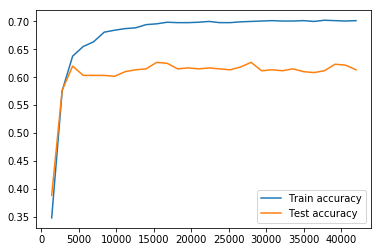

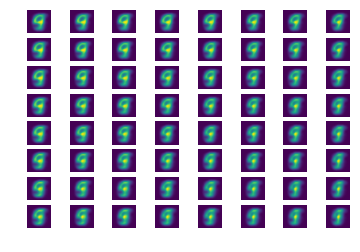

Number of correct predictions for training set: 982
Training accuracy: 0.701428571429
---------------------------------------
Number of correct predictions for testing set: 368
Test accuracy: 0.613333333333
---------------------------------------


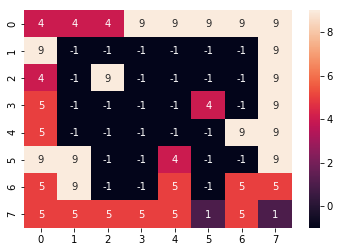

In [78]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 7,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.413, Test accuracy: 0.392
Epoch 2 ------ Train accuracy: 0.525, Test accuracy: 0.47
Epoch 3 ------ Train accuracy: 0.681, Test accuracy: 0.635
Epoch 4 ------ Train accuracy: 0.639, Test accuracy: 0.558
Epoch 5 ------ Train accuracy: 0.621, Test accuracy: 0.543
Epoch 6 ------ Train accuracy: 0.627, Test accuracy: 0.542
Epoch 7 ------ Train accuracy: 0.64, Test accuracy: 0.555
Epoch 8 ------ Train accuracy: 0.642, Test accuracy: 0.587
Epoch 9 ------ Train accuracy: 0.656, Test accuracy: 0.588
Epoch 10 ------ Train accuracy: 0.656, Test accuracy: 0.588
Epoch 11 ------ Train accuracy: 0.654, Test accuracy: 0.587
Epoch 12 ------ Train accuracy: 0.661, Test accuracy: 0.592
Epoch 13 ------ Train accuracy: 0.671, Test accuracy: 0.597
Epoch 14 ------ Train accuracy: 0.672, Test accuracy: 0.597
Epoch 15 ------ Train accuracy: 0.676, Test accuracy: 0.6
Epoch 16 ------ Train accuracy: 0.678, Test accuracy: 0.605
Epoch 17 ------ Train accuracy: 0.679, Test accuracy:

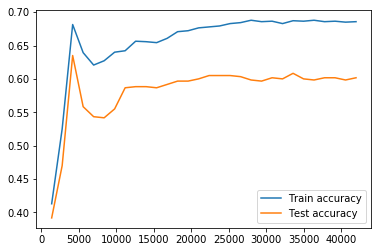

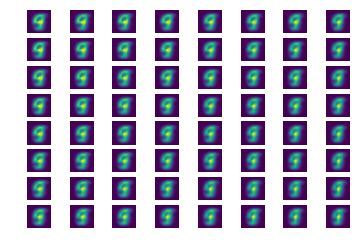

Number of correct predictions for training set: 960
Training accuracy: 0.685714285714
---------------------------------------
Number of correct predictions for testing set: 361
Test accuracy: 0.601666666667
---------------------------------------


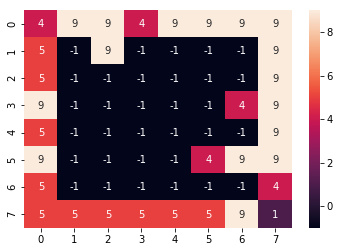

In [79]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 8,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.388, Test accuracy: 0.375
Epoch 2 ------ Train accuracy: 0.528, Test accuracy: 0.507
Epoch 3 ------ Train accuracy: 0.673, Test accuracy: 0.615
Epoch 4 ------ Train accuracy: 0.629, Test accuracy: 0.558
Epoch 5 ------ Train accuracy: 0.587, Test accuracy: 0.528
Epoch 6 ------ Train accuracy: 0.591, Test accuracy: 0.517
Epoch 7 ------ Train accuracy: 0.592, Test accuracy: 0.527
Epoch 8 ------ Train accuracy: 0.608, Test accuracy: 0.55
Epoch 9 ------ Train accuracy: 0.616, Test accuracy: 0.547
Epoch 10 ------ Train accuracy: 0.623, Test accuracy: 0.555
Epoch 11 ------ Train accuracy: 0.631, Test accuracy: 0.563
Epoch 12 ------ Train accuracy: 0.636, Test accuracy: 0.577
Epoch 13 ------ Train accuracy: 0.64, Test accuracy: 0.58
Epoch 14 ------ Train accuracy: 0.643, Test accuracy: 0.582
Epoch 15 ------ Train accuracy: 0.646, Test accuracy: 0.58
Epoch 16 ------ Train accuracy: 0.646, Test accuracy: 0.567
Epoch 17 ------ Train accuracy: 0.644, Test accuracy:

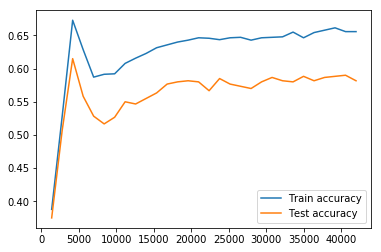

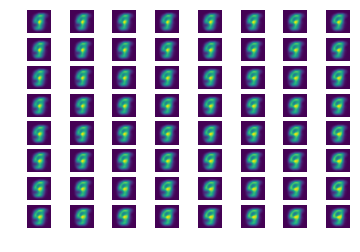

Number of correct predictions for training set: 918
Training accuracy: 0.655714285714
---------------------------------------
Number of correct predictions for testing set: 349
Test accuracy: 0.581666666667
---------------------------------------


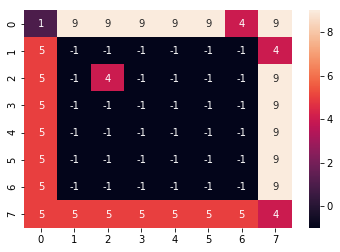

In [80]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 9,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

Epoch 1 ------ Train accuracy: 0.578, Test accuracy: 0.54
Epoch 2 ------ Train accuracy: 0.631, Test accuracy: 0.572
Epoch 3 ------ Train accuracy: 0.64, Test accuracy: 0.585
Epoch 4 ------ Train accuracy: 0.636, Test accuracy: 0.598
Epoch 5 ------ Train accuracy: 0.641, Test accuracy: 0.612
Epoch 6 ------ Train accuracy: 0.639, Test accuracy: 0.612
Epoch 7 ------ Train accuracy: 0.641, Test accuracy: 0.602
Epoch 8 ------ Train accuracy: 0.646, Test accuracy: 0.612
Epoch 9 ------ Train accuracy: 0.646, Test accuracy: 0.615
Epoch 10 ------ Train accuracy: 0.646, Test accuracy: 0.595
Epoch 11 ------ Train accuracy: 0.634, Test accuracy: 0.598
Epoch 12 ------ Train accuracy: 0.566, Test accuracy: 0.515
Epoch 13 ------ Train accuracy: 0.506, Test accuracy: 0.482
Epoch 14 ------ Train accuracy: 0.48, Test accuracy: 0.472
Epoch 15 ------ Train accuracy: 0.477, Test accuracy: 0.468
Epoch 16 ------ Train accuracy: 0.481, Test accuracy: 0.472
Epoch 17 ------ Train accuracy: 0.48, Test accuracy:

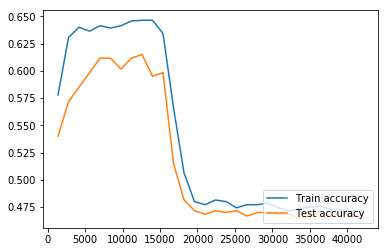

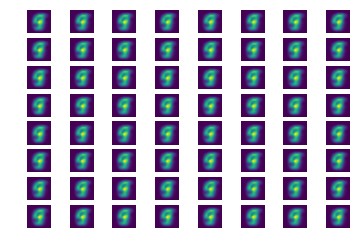

Number of correct predictions for training set: 660
Training accuracy: 0.471428571429
---------------------------------------
Number of correct predictions for testing set: 280
Test accuracy: 0.466666666667
---------------------------------------


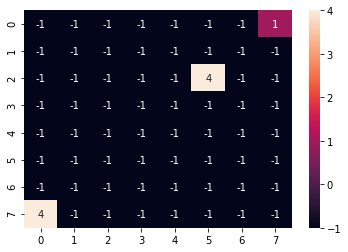

In [85]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 1000,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 30
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'])

In [97]:
y = np.array([[0.4, 36.3, 'Train'], 
              [0.5, 70.1, 'Train'],
              [1, 72.6, 'Train'],
              [2, 75.1, 'Train'],
              [3, 73.8, 'Train'],
              [4, 73.9, 'Train'],
              [5, 73.1, 'Train'],
              [6, 72.2, 'Train'],
              [7, 70.1, 'Train'],
              [8, 68.6, 'Train'],
              [9, 65.6, 'Train'],
              [1000, 47.1, 'Train'],
              
              [0.4, 36.3, 'Test'], 
              [0.5, 65.2, 'Test'],
              [1, 71.8, 'Test'],
              [2, 71.8, 'Test'],
              [3, 66.5, 'Test'],
              [4, 66.5, 'Test'],
              [5, 65.7, 'Test'],
              [6, 63.8, 'Test'],
              [7, 61.3, 'Test'],
              [8, 60.2, 'Test'],
              [9, 58.2, 'Test'],
              [1000, 46.7, 'Test'],
             ])
y = pd.DataFrame(y, columns = ['sigma', 'Accuracy', 'Dataset'])
y['sigma'] = pd.to_numeric(y['sigma'])
y['Accuracy'] = pd.to_numeric(y['Accuracy'])
test_results['vary_sigma'] = y

Text(0.5,1,u'size_k = 8, eta = 0.0008, epoch = 30')

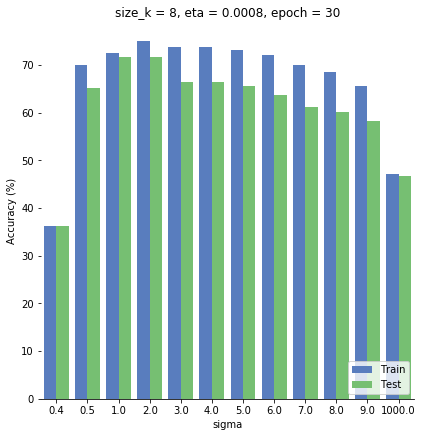

In [98]:
g_ = sns.factorplot("sigma", "Accuracy", "Dataset",
                    data=test_results['vary_sigma'], kind="bar",
                    size=6, palette="muted",
                   legend_out=False)
g_.despine(left=True)
plt.legend(loc='lower right')
g_.set_ylabels("Accuracy (%)")
plt.title("size_k = 8, eta = 0.0008, epoch = 30")

### 4. Until now, the width of the neighborhood function has been constant. Now, start with a large $\sigma$ and decrease it over the runtime of the algorithm. Does it improve your result?

('Train accuracy: 0.263571428571', 'Test accuracy: 0.255')
('Train accuracy: 0.345', 'Test accuracy: 0.338333333333')
('Train accuracy: 0.53', 'Test accuracy: 0.535')
('Train accuracy: 0.602857142857', 'Test accuracy: 0.543333333333')
('Train accuracy: 0.637142857143', 'Test accuracy: 0.586666666667')
('Train accuracy: 0.677857142857', 'Test accuracy: 0.61')
('Train accuracy: 0.7', 'Test accuracy: 0.658333333333')
('Train accuracy: 0.721428571429', 'Test accuracy: 0.653333333333')
('Train accuracy: 0.737142857143', 'Test accuracy: 0.651666666667')
('Train accuracy: 0.746428571429', 'Test accuracy: 0.66')
('Train accuracy: 0.751428571429', 'Test accuracy: 0.675')
('Train accuracy: 0.757142857143', 'Test accuracy: 0.686666666667')
('Train accuracy: 0.765', 'Test accuracy: 0.693333333333')
('Train accuracy: 0.765', 'Test accuracy: 0.696666666667')
('Train accuracy: 0.765', 'Test accuracy: 0.71')
('Train accuracy: 0.768571428571', 'Test accuracy: 0.715')
('Train accuracy: 0.774285714286', 

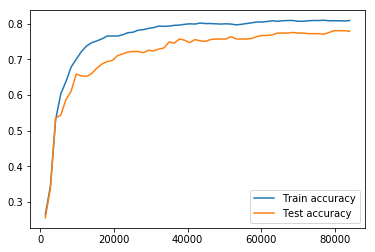

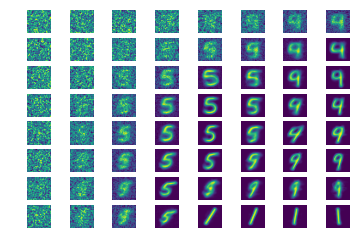

Number of correct predictions for training set: 1132
Training accuracy: 0.808571428571
---------------------------------------
Number of correct predictions for testing set: 467
Test accuracy: 0.778333333333
---------------------------------------


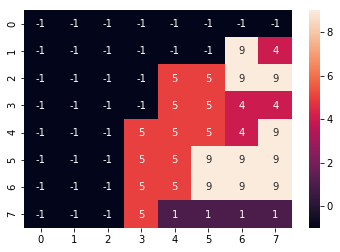

In [109]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 60
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'],
                       sigma_decay=True)

('Train accuracy: 0.295', 'Test accuracy: 0.306666666667')
('Train accuracy: 0.378571428571', 'Test accuracy: 0.398333333333')
('Train accuracy: 0.606428571429', 'Test accuracy: 0.59')
('Train accuracy: 0.666428571429', 'Test accuracy: 0.6')
('Train accuracy: 0.702857142857', 'Test accuracy: 0.633333333333')
('Train accuracy: 0.724285714286', 'Test accuracy: 0.651666666667')
('Train accuracy: 0.723571428571', 'Test accuracy: 0.66')
('Train accuracy: 0.734285714286', 'Test accuracy: 0.66')
('Train accuracy: 0.73', 'Test accuracy: 0.7')
('Train accuracy: 0.741428571429', 'Test accuracy: 0.716666666667')
('Train accuracy: 0.742142857143', 'Test accuracy: 0.72')
('Train accuracy: 0.745', 'Test accuracy: 0.708333333333')
('Train accuracy: 0.751428571429', 'Test accuracy: 0.706666666667')
('Train accuracy: 0.756428571429', 'Test accuracy: 0.71')
('Train accuracy: 0.76', 'Test accuracy: 0.715')
('Train accuracy: 0.762142857143', 'Test accuracy: 0.718333333333')
('Train accuracy: 0.76285714285

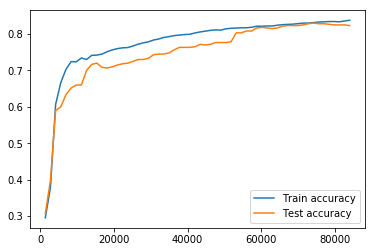

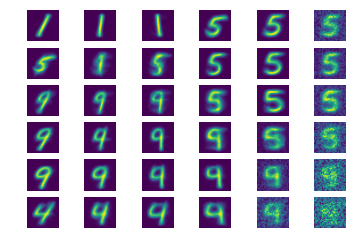

Number of correct predictions for training set: 1173
Training accuracy: 0.837857142857
---------------------------------------
Number of correct predictions for testing set: 494
Test accuracy: 0.823333333333
---------------------------------------


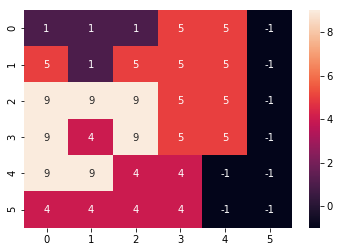

In [110]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 6,
    'eta': 0.0008,
    'epoch': 60
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'],
                       sigma_decay=True)

('Train accuracy: 0.292142857143', 'Test accuracy: 0.303333333333')
('Train accuracy: 0.440714285714', 'Test accuracy: 0.45')
('Train accuracy: 0.616428571429', 'Test accuracy: 0.561666666667')
('Train accuracy: 0.695', 'Test accuracy: 0.623333333333')
('Train accuracy: 0.717857142857', 'Test accuracy: 0.653333333333')
('Train accuracy: 0.730714285714', 'Test accuracy: 0.705')
('Train accuracy: 0.729285714286', 'Test accuracy: 0.666666666667')
('Train accuracy: 0.722142857143', 'Test accuracy: 0.661666666667')
('Train accuracy: 0.720714285714', 'Test accuracy: 0.69')
('Train accuracy: 0.728571428571', 'Test accuracy: 0.685')
('Train accuracy: 0.735714285714', 'Test accuracy: 0.69')
('Train accuracy: 0.734285714286', 'Test accuracy: 0.693333333333')
('Train accuracy: 0.74', 'Test accuracy: 0.698333333333')
('Train accuracy: 0.743571428571', 'Test accuracy: 0.701666666667')
('Train accuracy: 0.745', 'Test accuracy: 0.698333333333')
('Train accuracy: 0.75', 'Test accuracy: 0.715')
('Train

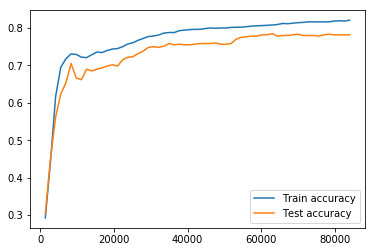

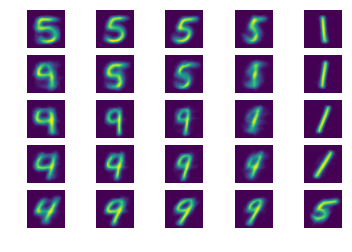

Number of correct predictions for training set: 1149
Training accuracy: 0.820714285714
---------------------------------------
Number of correct predictions for testing set: 469
Test accuracy: 0.781666666667
---------------------------------------


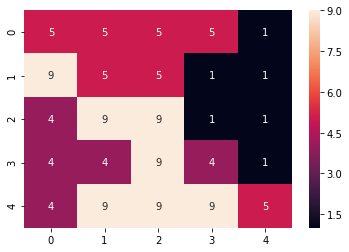

In [111]:
config = {
    'targetdigits': [1, 4, 5, 9],
    'sigma': 3,
    'size_k': 5,
    'eta': 0.0008,
    'epoch': 60
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'],
                       sigma_decay=True)

('Train accuracy: 0.261785714286', 'Test accuracy: 0.261666666667')
('Train accuracy: 0.4425', 'Test accuracy: 0.415')
('Train accuracy: 0.487857142857', 'Test accuracy: 0.455')
('Train accuracy: 0.503928571429', 'Test accuracy: 0.4675')
('Train accuracy: 0.518214285714', 'Test accuracy: 0.485833333333')
('Train accuracy: 0.537857142857', 'Test accuracy: 0.501666666667')
('Train accuracy: 0.561071428571', 'Test accuracy: 0.545833333333')
('Train accuracy: 0.595', 'Test accuracy: 0.5775')
('Train accuracy: 0.623214285714', 'Test accuracy: 0.594166666667')
('Train accuracy: 0.639285714286', 'Test accuracy: 0.6175')
('Train accuracy: 0.66', 'Test accuracy: 0.6425')
('Train accuracy: 0.6725', 'Test accuracy: 0.658333333333')
('Train accuracy: 0.681785714286', 'Test accuracy: 0.674166666667')
('Train accuracy: 0.693928571429', 'Test accuracy: 0.681666666667')
('Train accuracy: 0.703928571429', 'Test accuracy: 0.703333333333')
('Train accuracy: 0.714642857143', 'Test accuracy: 0.714166666667

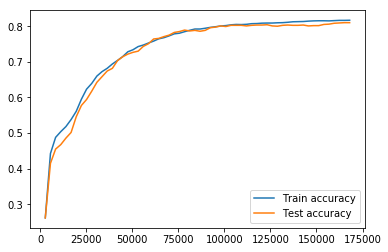

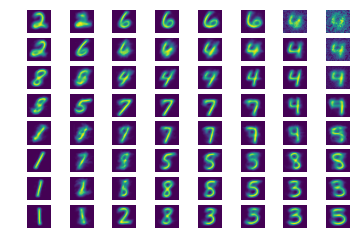

Number of correct predictions for training set: 2287
Training accuracy: 0.816785714286
---------------------------------------
Number of correct predictions for testing set: 972
Test accuracy: 0.81
---------------------------------------


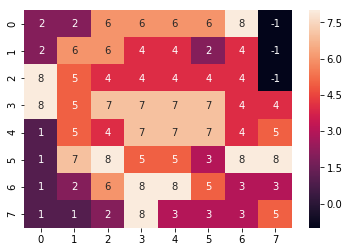

In [112]:
config = {
    'targetdigits': [1, 2, 3, 4, 5, 6, 7, 8],
    'sigma': 3,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 60
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'],
                       sigma_decay=True)

('Train accuracy: 0.289142857143', 'Test accuracy: 0.292')
('Train accuracy: 0.395714285714', 'Test accuracy: 0.374666666667')
('Train accuracy: 0.414', 'Test accuracy: 0.378666666667')
('Train accuracy: 0.448285714286', 'Test accuracy: 0.424666666667')
('Train accuracy: 0.481142857143', 'Test accuracy: 0.465333333333')
('Train accuracy: 0.499142857143', 'Test accuracy: 0.474666666667')
('Train accuracy: 0.515714285714', 'Test accuracy: 0.472666666667')
('Train accuracy: 0.536571428571', 'Test accuracy: 0.508')
('Train accuracy: 0.552857142857', 'Test accuracy: 0.527333333333')
('Train accuracy: 0.564571428571', 'Test accuracy: 0.532')
('Train accuracy: 0.579714285714', 'Test accuracy: 0.548666666667')
('Train accuracy: 0.590285714286', 'Test accuracy: 0.559333333333')
('Train accuracy: 0.601428571429', 'Test accuracy: 0.568666666667')
('Train accuracy: 0.614285714286', 'Test accuracy: 0.588')
('Train accuracy: 0.621714285714', 'Test accuracy: 0.594666666667')
('Train accuracy: 0.63085

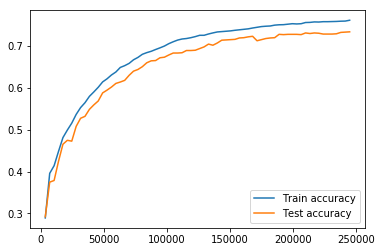

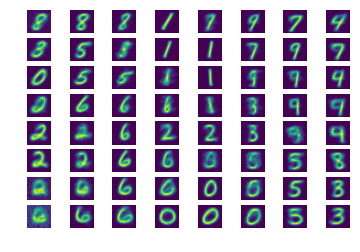

Number of correct predictions for training set: 2666
Training accuracy: 0.761714285714
---------------------------------------
Number of correct predictions for testing set: 1101
Test accuracy: 0.734
---------------------------------------


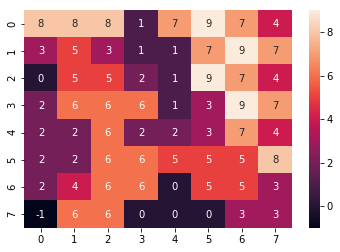

In [3]:
config = {
    'targetdigits': [1, 2, 3, 4, 5, 6, 7, 8, 9, 0],
    'sigma': 3,
    'size_k': 8,
    'eta': 0.0008,
    'epoch': 70
}

kohonen_learning_curve(targetdigits=config['targetdigits'], 
                       _sigma =config['sigma'], 
                       _size_k=config['size_k'], 
                       _eta=config['eta'], 
                       epoch=config['epoch'],
                       sigma_decay=True)